# DDPM with cats dataset

## import necessary modules 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

from torch.utils.tensorboard import SummaryWriter

## set agnostic

In [2]:
# agnostic code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## load data set

In [3]:
# set image size
img_size = 64

# Set the path to the dataset
dataset_path = 'dataset/cats/'

# Set the number of images to transform
NUM_IMAGES = 15747

In [4]:
# Get the list of image filenames
image_filenames = os.listdir(dataset_path)

# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), # convert PIL image to tensor and scales data into [0,1] 
    # transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1] 
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]), # Scale between [-1, 1] by (input[channel] - mean[channel]) / std[channel]
])

# Create a list to store the transformed images
transformed_images = []

# Iterate over the first num_images filenames and transform the corresponding images
for i, filename in enumerate(image_filenames[:NUM_IMAGES]):
    # Load the image
    img_path = os.path.join(dataset_path, filename)
    image = Image.open(img_path)

    # Apply the transformations
    transformed_image = transform(image)

    # Append the transformed image to the list
    transformed_images.append(transformed_image)

# Convert the list of transformed images to a PyTorch tensor
transformed_images = torch.stack(transformed_images)

print(f'Loaded data: {transformed_images.shape}')

Loaded data: torch.Size([15747, 3, 64, 64])


## split batch size 

In [5]:
# set batch size
batch_size = 16

data_loader = DataLoader(transformed_images, batch_size=batch_size, shuffle=True, drop_last=True)

data_iter = iter(data_loader)
print(next(data_iter).shape)

torch.Size([16, 3, 64, 64])


## import the model

base on DDPM and unet papers 
https://arxiv.org/pdf/1505.04597v1.pdf

In [6]:
from modules.ddpm import Diffusion

from modules.modules import UNet

## Set hyperparameter before training iteration

In [7]:
# base on the paper
LEARNING_RATE = 1e-4  #0.0001
# LEARNING_RATE = 1e-5  #0.00001

BATCH_SIZE = 16
IMAGE_SIZE = 64
CHANNELS_IMG = 3
NUM_EPOCHS = 100



## Train model and save weight and log 

## training process
parameter base on DDPM paper 

In [23]:
import logging
import time

model = UNet().to(device)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
mse = nn.MSELoss()
diffusion = Diffusion(img_size=IMAGE_SIZE, device=device)
writer = SummaryWriter(os.path.join("logs/cats","DDPM"))

l = len(data_loader)

time_use = 0

for epoch in range(NUM_EPOCHS):

    # Shuffle the dataset at the beginning of each epoch
    data_loader = DataLoader(transformed_images, batch_size=batch_size, shuffle=True, drop_last=True)

    lossMean = 0

    # logging.info(f"Starting epoch {epoch}:")

    # use time for time measurement
    start_time = time.time()

    model.train()
    for batch_idx, images in enumerate(data_loader):
        images = images.to(device)
        t = diffusion.sample_timesteps(images.shape[0]).to(device)
        x_t, noise = diffusion.noise_images(images, t)
        predicted_noise = model(x_t, t)
        loss = mse(noise, predicted_noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # sum lose
        lossMean += loss

    end_time = time.time()
    epoch_time = end_time - start_time

    time_use += epoch_time 

    epoch_index = epoch+1

    # calculate mean value
    lossMean = lossMean / len(data_loader.dataset)

    print(
        f"Epoch [{epoch_index}/{NUM_EPOCHS}] Batch {batch_idx+1}/{len(data_loader)} Using Time: {epoch_time:.4f}\
            Loss: {lossMean:.4f}"
    )

    # tensorboard
    writer.add_scalar("MSE", lossMean, global_step=epoch+1)
    writer.add_scalar("traing time", time_use, epoch_index)

    torch.save(model.state_dict(), os.path.join("weights", "cats", "DDPM", f"{epoch_index}.pt"))

    model.eval()
    with torch.no_grad():
        x = diffusion.sample(model, n=32).type(dtype=torch.float32)
        img_grid = torchvision.utils.make_grid(x[:32], normalize=True)
        writer.add_image("All/Generate Images", img_grid, global_step=epoch_index)


06:53:26 - INFO: Starting epoch 0:


Epoch [1/200] Batch 984/984 Using Time: 255.3108            Loss: 0.0069


06:57:41 - INFO: Sampling 32 new images....
999it [02:46,  6.00it/s]
07:00:28 - INFO: Starting epoch 1:
07:04:53 - INFO: Sampling 32 new images....


Epoch [2/200] Batch 984/984 Using Time: 264.4355            Loss: 0.0032


999it [02:45,  6.03it/s]
07:07:39 - INFO: Starting epoch 2:


Epoch [3/200] Batch 984/984 Using Time: 261.2730            Loss: 0.0027


07:12:01 - INFO: Sampling 32 new images....
999it [02:45,  6.04it/s]
07:14:47 - INFO: Starting epoch 3:


Epoch [4/200] Batch 984/984 Using Time: 259.9018            Loss: 0.0027


07:19:08 - INFO: Sampling 32 new images....
999it [02:45,  6.05it/s]
07:21:54 - INFO: Starting epoch 4:


Epoch [5/200] Batch 984/984 Using Time: 259.8262            Loss: 0.0025


07:26:14 - INFO: Sampling 32 new images....
999it [02:44,  6.07it/s]
07:28:59 - INFO: Starting epoch 5:


Epoch [6/200] Batch 984/984 Using Time: 259.7389            Loss: 0.0023


07:33:19 - INFO: Sampling 32 new images....
999it [02:46,  6.02it/s]
07:36:06 - INFO: Starting epoch 6:
07:40:30 - INFO: Sampling 32 new images....


Epoch [7/200] Batch 984/984 Using Time: 264.1362            Loss: 0.0023


999it [02:45,  6.03it/s]
07:43:16 - INFO: Starting epoch 7:
07:47:38 - INFO: Sampling 32 new images....


Epoch [8/200] Batch 984/984 Using Time: 261.2928            Loss: 0.0022


999it [02:46,  6.01it/s]
07:50:25 - INFO: Starting epoch 8:
07:54:48 - INFO: Sampling 32 new images....


Epoch [9/200] Batch 984/984 Using Time: 262.7316            Loss: 0.0022


999it [02:46,  5.99it/s]
07:57:35 - INFO: Starting epoch 9:
08:01:58 - INFO: Sampling 32 new images....


Epoch [10/200] Batch 984/984 Using Time: 263.3582            Loss: 0.0021


999it [02:47,  5.96it/s]
08:04:47 - INFO: Starting epoch 10:
08:09:13 - INFO: Sampling 32 new images....


Epoch [11/200] Batch 984/984 Using Time: 265.6976            Loss: 0.0022


999it [02:49,  5.89it/s]
08:12:03 - INFO: Starting epoch 11:


Epoch [12/200] Batch 984/984 Using Time: 265.9931            Loss: 0.0020


08:16:29 - INFO: Sampling 32 new images....
999it [02:50,  5.88it/s]
08:19:20 - INFO: Starting epoch 12:


Epoch [13/200] Batch 984/984 Using Time: 267.8061            Loss: 0.0020


08:23:48 - INFO: Sampling 32 new images....
999it [02:50,  5.85it/s]
08:26:40 - INFO: Starting epoch 13:
08:31:08 - INFO: Sampling 32 new images....


Epoch [14/200] Batch 984/984 Using Time: 268.1376            Loss: 0.0020


999it [02:51,  5.84it/s]
08:34:00 - INFO: Starting epoch 14:
08:38:28 - INFO: Sampling 32 new images....


Epoch [15/200] Batch 984/984 Using Time: 268.2351            Loss: 0.0020


999it [02:51,  5.83it/s]
08:41:20 - INFO: Starting epoch 15:
08:45:49 - INFO: Sampling 32 new images....


Epoch [16/200] Batch 984/984 Using Time: 268.3762            Loss: 0.0020


999it [02:51,  5.84it/s]
08:48:40 - INFO: Starting epoch 16:


Epoch [17/200] Batch 984/984 Using Time: 268.7173            Loss: 0.0019


08:53:09 - INFO: Sampling 32 new images....
999it [02:51,  5.83it/s]
08:56:01 - INFO: Starting epoch 17:


Epoch [18/200] Batch 984/984 Using Time: 268.7952            Loss: 0.0019


09:00:31 - INFO: Sampling 32 new images....
999it [02:51,  5.82it/s]
09:03:23 - INFO: Starting epoch 18:
09:07:52 - INFO: Sampling 32 new images....


Epoch [19/200] Batch 984/984 Using Time: 268.5911            Loss: 0.0019


999it [02:51,  5.82it/s]
09:10:44 - INFO: Starting epoch 19:


Epoch [20/200] Batch 984/984 Using Time: 268.7843            Loss: 0.0019


09:15:13 - INFO: Sampling 32 new images....
999it [02:51,  5.82it/s]
09:18:06 - INFO: Starting epoch 20:
09:22:35 - INFO: Sampling 32 new images....


Epoch [21/200] Batch 984/984 Using Time: 269.1617            Loss: 0.0018


999it [02:51,  5.81it/s]
09:25:27 - INFO: Starting epoch 21:


Epoch [22/200] Batch 984/984 Using Time: 268.9042            Loss: 0.0019


09:29:57 - INFO: Sampling 32 new images....
999it [02:51,  5.82it/s]
09:32:49 - INFO: Starting epoch 22:
09:37:19 - INFO: Sampling 32 new images....


Epoch [23/200] Batch 984/984 Using Time: 269.4041            Loss: 0.0019


999it [02:51,  5.81it/s]
09:40:11 - INFO: Starting epoch 23:


Epoch [24/200] Batch 984/984 Using Time: 269.1417            Loss: 0.0019


09:44:41 - INFO: Sampling 32 new images....
999it [02:51,  5.81it/s]
09:47:34 - INFO: Starting epoch 24:
09:52:03 - INFO: Sampling 32 new images....


Epoch [25/200] Batch 984/984 Using Time: 269.3321            Loss: 0.0018


999it [02:52,  5.80it/s]
09:54:56 - INFO: Starting epoch 25:


Epoch [26/200] Batch 984/984 Using Time: 269.5257            Loss: 0.0019


09:59:26 - INFO: Sampling 32 new images....
999it [02:51,  5.81it/s]
10:02:18 - INFO: Starting epoch 26:
10:06:48 - INFO: Sampling 32 new images....


Epoch [27/200] Batch 984/984 Using Time: 269.7357            Loss: 0.0019


999it [02:51,  5.81it/s]
10:09:40 - INFO: Starting epoch 27:


Epoch [28/200] Batch 984/984 Using Time: 269.1343            Loss: 0.0019


10:14:11 - INFO: Sampling 32 new images....
999it [02:51,  5.81it/s]
10:17:04 - INFO: Starting epoch 28:


Epoch [29/200] Batch 984/984 Using Time: 269.5513            Loss: 0.0018


10:21:34 - INFO: Sampling 32 new images....
999it [02:52,  5.80it/s]
10:24:27 - INFO: Starting epoch 29:
10:28:57 - INFO: Sampling 32 new images....


Epoch [30/200] Batch 984/984 Using Time: 270.0007            Loss: 0.0018


999it [02:52,  5.79it/s]
10:31:50 - INFO: Starting epoch 30:
10:36:19 - INFO: Sampling 32 new images....


Epoch [31/200] Batch 984/984 Using Time: 268.9190            Loss: 0.0018


999it [02:50,  5.86it/s]
10:39:10 - INFO: Starting epoch 31:


Epoch [32/200] Batch 984/984 Using Time: 266.8575            Loss: 0.0018


10:43:38 - INFO: Sampling 32 new images....
999it [02:51,  5.81it/s]
10:46:30 - INFO: Starting epoch 32:


Epoch [33/200] Batch 984/984 Using Time: 269.8352            Loss: 0.0018


10:51:01 - INFO: Sampling 32 new images....
999it [02:52,  5.79it/s]
10:53:54 - INFO: Starting epoch 33:


KeyboardInterrupt: 

# Measure FID

use this implementation: https://github.com/mseitzer/pytorch-fid/tree/master

## define FID measurement function 

In [43]:
import subprocess
import torch
from torchvision.utils import save_image
import re

# Create a function to run the FID script
def run_fid(real_path, gen_path, epoch):
    command = ["python", "-m", "pytorch_fid", real_path, gen_path]

    output = subprocess.run(command, capture_output=True, text=True)

    # Extract the FID score using regular expressions
    output = output.stdout
    fid_score_match = re.search(r"FID:\s+(\d+\.\d+)", output)
    
    if fid_score_match:
        fid_score = float(fid_score_match.group(1))
        print("FID score:", fid_score)

        # Write the FID score to the log file
        # gen_log(log_path="logs/cats/fid/DCGAN.log", message=f"Epoch: {epoch}, FID score: {fid_score}")
        
    else:
        print("FID score not found in the output.")

    return fid_score

def FID_measure(model, sample_n=100*8, batch_size=8, device="cpu", real_path="dataset/cats/", gen_path="generated_images", epoch=int):
    # Set the model to evaluation mode
    model.eval()

    # Create a folder for generated images if it doesn't exist
    os.makedirs(gen_path, exist_ok=True)
    torch.manual_seed(2023)

    # Generate images
    with torch.no_grad():
        for i in range(0, sample_n, batch_size):
            
            x = diffusion.sample(model, n=batch_size).type(dtype=torch.float32)

            for j in range(batch_size):
                save_image(x[j], f"{gen_path}/{i+j}.png", normalize=True)
        
    # Measure FID score between the real and generated images
    fid_score = run_fid(real_path, gen_path, epoch)
    return fid_score


## Load weight of model to measure FID score

In [44]:
def load_weight( model, weight_path="", index=int):

    # Load the saved weights
    model.load_state_dict(torch.load(f'{weight_path}/{index}.pt'))
    

In [49]:
import glob
from pathlib import Path
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(f'logs/cats/DDPM/')

# Specify the directory path
directory_path = Path('weights/cats/DDPM/')

# Get the list of files ending with ".pth"
# file_list = list(directory_path.glob('*.pt'))


model = UNet().to(device)

sample_size = 10000

for i in range(NUM_EPOCHS):
    index_weight = i+1

    load_weight(model, weight_path=directory_path, index=index_weight)

    print('Epoch: ',index_weight)
    fid_score = FID_measure(model, sample_size, batch_size=64, device=f"{device}", gen_path=f"gen_image/cats/DDPM/{index_weight}/", epoch=index_weight)   
    
    writer.add_scalar("Metrics/FID Score", fid_score, index_weight)


11:38:55 - INFO: Sampling 64 new images....


Epoch:  1


999it [06:15,  2.66it/s]
11:45:10 - INFO: Sampling 64 new images....
563it [03:33,  2.64it/s]


KeyboardInterrupt: 

# dummy plot

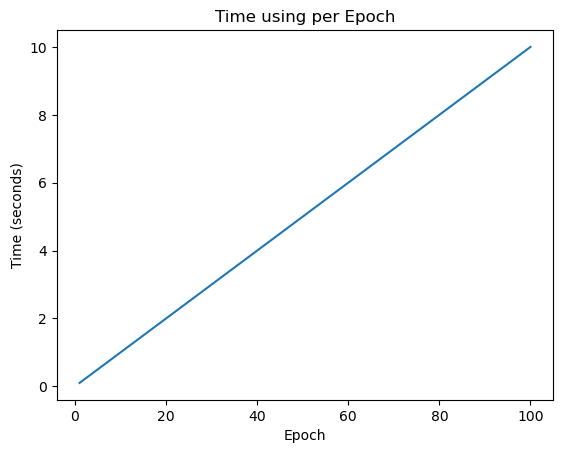

In [3]:
import matplotlib.pyplot as plt
import time

# Dummy data for demonstration
epochs = range(1, 101)
time_taken = [0.1 * epoch for epoch in epochs]  # Dummy time data (replace with actual time measurements)

# Plotting the graph
plt.plot(epochs, time_taken)
plt.xlabel('Epoch')
plt.ylabel('Time (seconds)')
plt.title('Time using per Epoch')
plt.show()


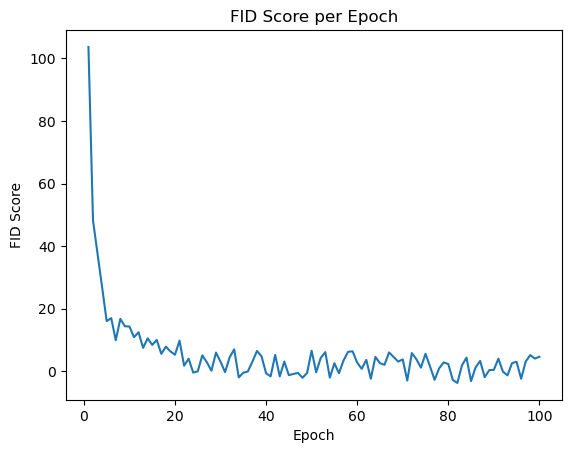

In [6]:
import matplotlib.pyplot as plt
import random

# Dummy data for demonstration
epochs = range(1, 101)
fid_scores = [100 / epoch + random.uniform(-5, 5) for epoch in epochs]  # Dummy FID scores with random variation

# Plotting the graph
plt.plot(epochs, fid_scores)
plt.xlabel('Epoch')
plt.ylabel('FID Score')
plt.title('FID Score per Epoch')
plt.show()
